In [1]:
from pathlib import Path
from src.utils.model_utils import seed_all
from src.utils.model_utils import get_device
from src.utils.data_class import ModelConfig
from src.utils.data_class import OptimConfig
from src.model.operations.train import run
from src.model.operations.forecast import iterative_forecast_from_last_val
from src.utils.plots import plot_forecast
import pandas as pd

In [2]:
seed_all(42)
device = get_device()
print(device)

DATA = Path("./../data/load")

# Example: pick first file
files = sorted([p for p in DATA.glob("*.csv")])
if not files:
    raise SystemExit(f"No CSVs found in {DATA}")

csv_path = str(files[0])

cuda


In [4]:
lookback = 30
horizon = 7
batch_size = 64
split_ratio = (0.6, 0.1, 0.3)
epochs = 100


regressor_name="xgboost"
regressor_params=dict(
    objective="reg:squarederror",
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
)

# ---- model config
cfg = ModelConfig(
    d_in=1,
    latent_dim=16,
    horizon=horizon,
    variational=False,
    beta_kl=1e-3,
    encoder_type="rnn",  # "rnn" or "mlp"
    decoder_type="mlp",  # "mlp" or "rnn"
    rnn_type="lstm",
    rnn_hidden=128,
    rnn_layers=2,
    rnn_dropout=0.0,
    mlp_hidden=128,
    mlp_layers=3,
    activation="relu",
    mlp_dropout=0.1,
    regressor_name=regressor_name,  # "linear","ridge","lasso","elasticnet","random_forest","extra_trees","xgboost"
    regressor_params=regressor_params,
    latent_feature_mode="flatten",  # "last","mean","flatten"
    optim=OptimConfig(name="adamw", lr=1e-3, weight_decay=1e-4),
)

loaders, scaler, model = run(
    csv_path=csv_path,
    lookback=lookback,
    horizon=horizon,
    split_ratio=split_ratio,
    batch_size=batch_size,
    cfg=cfg,
    epochs_ae=epochs,
    device=device,
    out_dir="../output",
)

[AE] epoch 001 | train 0.152367 | val 0.006512
[AE] epoch 002 | train 0.053439 | val 0.096620
[AE] epoch 003 | train 0.037321 | val 0.025727
[AE] epoch 004 | train 0.034322 | val 0.019903
[AE] epoch 005 | train 0.034284 | val 0.028927
[AE] epoch 006 | train 0.033017 | val 0.036829
[AE] epoch 007 | train 0.032772 | val 0.035423
[AE] epoch 008 | train 0.032488 | val 0.030868
[FORECAST] val:  {'mae': 0.04770905524492264, 'mse': 0.003612086409702897, 'rmse': 0.06010063737630844, 'mape': 10.395057678222656, 'r2': -0.10817122459411621, 'mda': 0.6477273106575012}
[FORECAST] test: {'mae': 0.15100900828838348, 'mse': 0.032841119915246964, 'rmse': 0.18122118711471558, 'mape': 23.911619186401367, 'r2': -1.2204468250274658, 'mda': 0.4563106894493103}


In [5]:
_, val_loader, test_loader = loaders


res = iterative_forecast_from_last_val(model, val_loader, device, 242, scaler)

In [6]:
df = pd.read_csv(csv_path)
all = df[["load"]]

val_index = int((1 - split_ratio[2]) * len(all))
y_true = all[val_index:].to_numpy()
y_pred = res.y_pred

results = pd.DataFrame(columns=["y_true", "y_pred", "effective_horizon"])
results["y_true"] = y_true.reshape(-1,)
results["y_pred"] = y_pred.reshape(-1,)
results["effective_horizon"] = 242

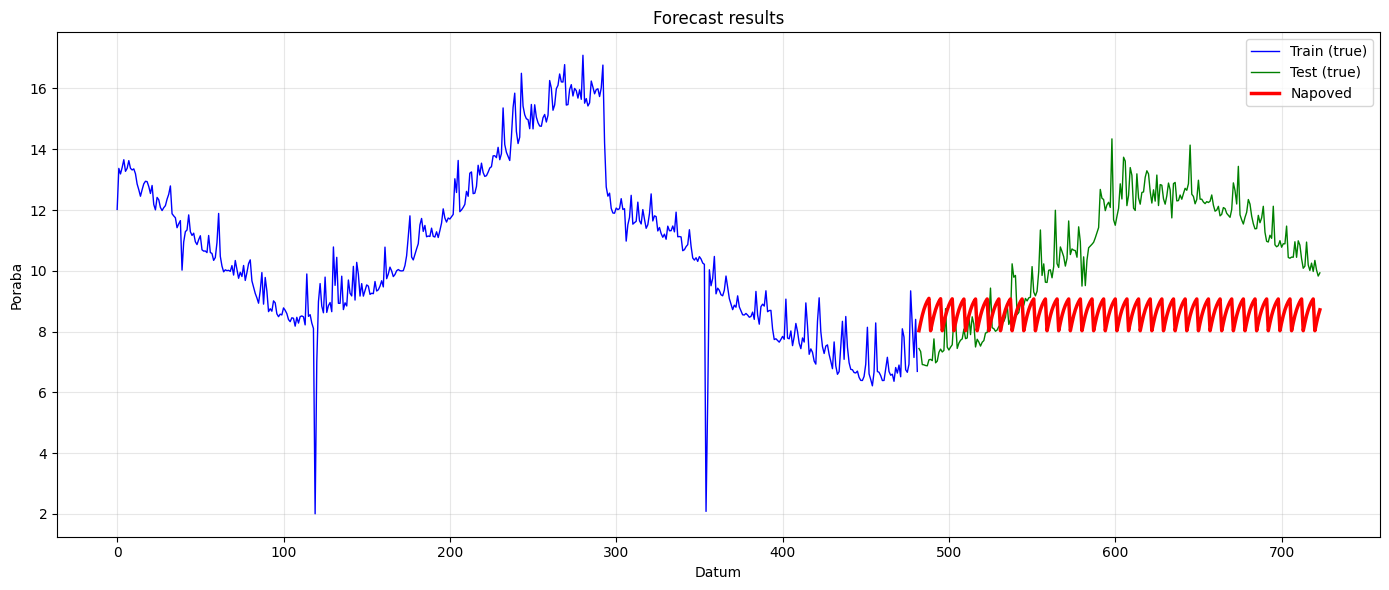

In [7]:
plot_forecast(pd.Series(df["load"]), results, split_ratio[0])